In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory



In [2]:
data = pd.read_csv('/kaggle/input/online-payments-fraud-detection-dataset/PS_20174392719_1491204439457_log.csv')
data.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
data.to_parquet('fraud_detection.parquet')

In [5]:
df = pd.read_parquet('/kaggle/working/fraud_detection.parquet')
df.head(2)

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0


In [6]:
df.isnull().sum()

step              0
type              0
amount            0
nameOrig          0
oldbalanceOrg     0
newbalanceOrig    0
nameDest          0
oldbalanceDest    0
newbalanceDest    0
isFraud           0
isFlaggedFraud    0
dtype: int64

In [7]:
df.duplicated().sum()

0

In [8]:
df.dtypes.value_counts()

float64    5
int64      3
object     3
Name: count, dtype: int64

In [9]:
df.select_dtypes('object').columns

Index(['type', 'nameOrig', 'nameDest'], dtype='object')

In [10]:
def types_count(col):
    return df[col].value_counts()

for col in df.select_dtypes('object').columns:
    print(types_count(col))
    print('#'*50)

type
CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: count, dtype: int64
##################################################
nameOrig
C1902386530    3
C363736674     3
C545315117     3
C724452879     3
C1784010646    3
              ..
C98968405      1
C720209255     1
C1567523029    1
C644777639     1
C1280323807    1
Name: count, Length: 6353307, dtype: int64
##################################################
nameDest
C1286084959    113
C985934102     109
C665576141     105
C2083562754    102
C248609774     101
              ... 
M1470027725      1
M1330329251      1
M1784358659      1
M2081431099      1
C2080388513      1
Name: count, Length: 2722362, dtype: int64
##################################################


In [11]:
cleaned_df =df.drop(['nameOrig','nameDest','isFlaggedFraud'], axis=1)

In [12]:
cleaned_df.head(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,170136.0,160296.36,0.0,0.0,0
1,1,PAYMENT,1864.28,21249.0,19384.72,0.0,0.0,0


In [13]:
cleaned_df.isFraud.value_counts()

isFraud
0    6354407
1       8213
Name: count, dtype: int64

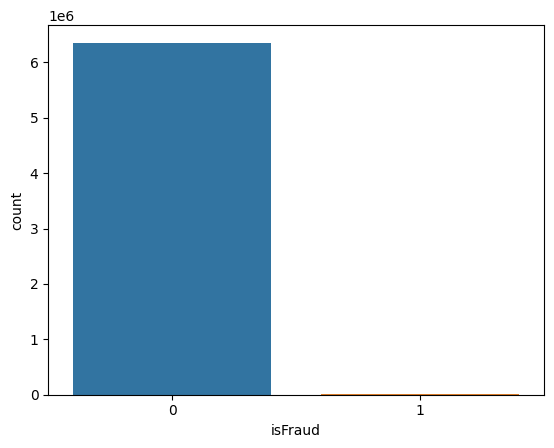

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.countplot(data=df, x= 'isFraud')
plt.show()

In [15]:
def down_sample(df):
    not_fraud = df[df['isFraud']==0].sample(n=8213, random_state=42)
    fraude = df[df['isFraud']==1]
    df = pd.concat([not_fraud , fraude], axis=0).reset_index(drop=True)
    return df
    
sample_df = down_sample(cleaned_df)

In [16]:
sample_df.head(2)

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
0,162,CASH_OUT,183806.32,19391.0,0.0,382572.19,566378.51,0
1,137,PAYMENT,521.37,0.0,0.0,0.00,0.00,0


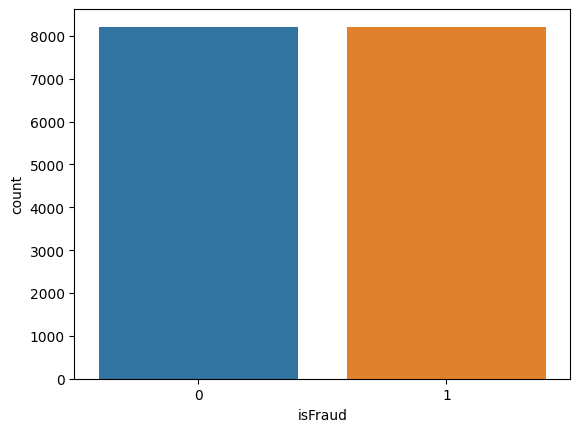

In [17]:
sns.countplot(data=sample_df, x= 'isFraud')
plt.show()

In [18]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.decomposition import TruncatedSVD

cat_col = make_column_selector(dtype_include= 'object')
num_col = make_column_selector(dtype_include='number')


cat_pipe=Pipeline([
    
    ('cat_impute', SimpleImputer(strategy= 'most_frequent')),
    ('ohe', OneHotEncoder(sparse_output= False, handle_unknown= 'ignore')),
    ('dr', TruncatedSVD(n_components=3))
    
    
])

num_pipe = Pipeline([
    
    ('num_impute', SimpleImputer(strategy= 'mean')),
    ('stand', StandardScaler(with_mean=True))
    
])
    
    
transformer = ColumnTransformer([
    
    ('cat', cat_pipe, cat_col),
    ('num', num_pipe, num_col)
]).set_output(transform='pandas')


print(transformer)

ColumnTransformer(transformers=[('cat',
                                 Pipeline(steps=[('cat_impute',
                                                  SimpleImputer(strategy='most_frequent')),
                                                 ('ohe',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse_output=False)),
                                                 ('dr',
                                                  TruncatedSVD(n_components=3))]),
                                 <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                ('num',
                                 Pipeline(steps=[('num_impute',
                                                  SimpleImputer()),
                                                 ('stand', StandardScaler())]),
                                 <sklearn.compose._column_tra

In [19]:
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict

features = sample_df.drop('isFraud', axis=1)
target= sample_df.isFraud
X_train, X_test, y_train, y_test =  train_test_split(features, target, test_size=.30, shuffle=True, stratify= target, random_state=42)

In [20]:
from sklearn.metrics import *
def model_eveluation(model, X_test= X_test, y_test= y_test):
    prediction = model.predict(X_test)
    print(f'the traning accuracy of the model is {round(accuracy_score(model.predict(X_train), y_train),4)*100}%')
    print(f'the testing accuracy of the model is {round(accuracy_score(prediction, y_test),4)*100}%')
    print(f'the precision of the model is {precision_score(prediction, y_test, average= "macro")}')
    print(f'the recall of the model is {recall_score(prediction, y_test, average="macro")}')
    print(f'the f1 of the model is {f1_score(prediction, y_test, average="macro")}')
    cm = confusion_matrix(prediction, y_test)
    ConfusionMatrixDisplay(cm).plot()

In [21]:
from sklearn.linear_model import LogisticRegression 

clf = Pipeline([
    
    ('transformer', transformer),
    ('model',LogisticRegression(max_iter=2000 , penalty= 'l2', C=1) )
])

clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model', LogisticRegression(C=1, max_iter=2000))])

In [22]:
cross_val_score(clf, features, target, cv=5, scoring='accuracy')

array([0.75867316, 0.88888889, 0.93881279, 0.97199391, 0.95829528])

In [23]:
cross_val_score(clf, features, target, cv=5, scoring='accuracy').mean()

0.9033328052871321

In [24]:
sum(cross_val_predict(clf, X_test, y_test)==y_test)/len(y_test)

0.9034090909090909

In [25]:
feature_names = clf['model'].feature_names_in_
model_coef = clf['model'].coef_
model_coef

array([[  4.40055071,   5.86346174,  -2.1157489 ,   0.56512994,
         -0.77487506,  19.75351174, -14.95906883,   5.18719142,
         -6.48700597]])

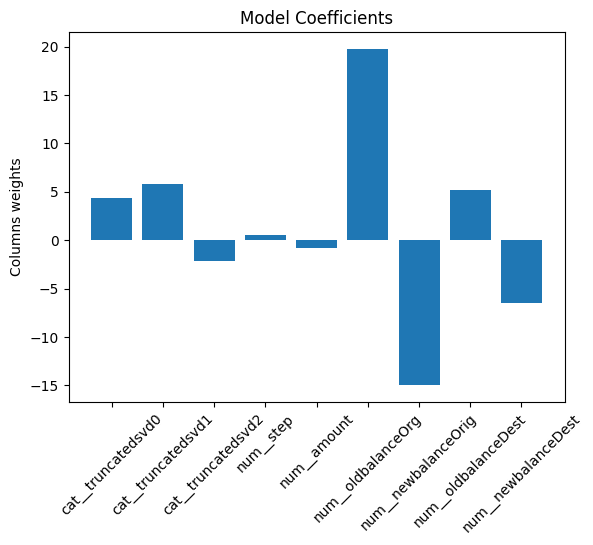

In [26]:
def plot_coef(feature_names, model_coef):
    
    plt.bar(feature_names, model_coef)
    plt.xticks(rotation=45)
    plt.ylabel('Columns weights')
    plt.title('Model Coefficients')
    plt.show()
    
plot_coef(feature_names, model_coef[0])

the traning accuracy of the model is 92.71000000000001%
the testing accuracy of the model is 92.29%
the precision of the model is 0.9228896103896105
the recall of the model is 0.9231240561034633
the f1 of the model is 0.9228789275268494


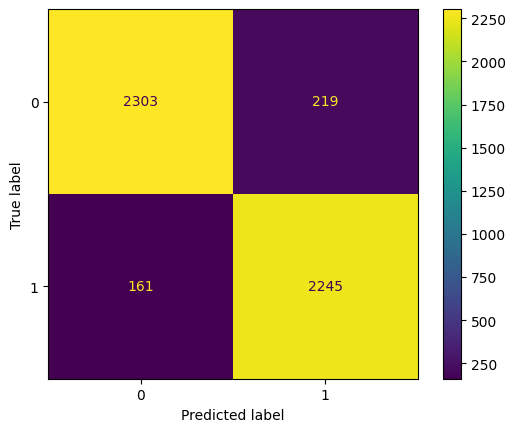

In [27]:
model_eveluation(clf)

## Tune Logistic Regression Pipeline

In [28]:
from sklearn.model_selection import GridSearchCV

params = {'transformer__cat__dr__n_components':[2,3],
         'transformer__num__stand__with_mean':[True, False],
          'transformer__num__num_impute__strategy':['mean', 'median'],
         'model__C':[0.001, 0.01, 0.1, 1, 10,100]}

gscv = GridSearchCV(clf, params, cv=3, scoring = 'f1', n_jobs=-1)

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('model',
                                        LogisticRegression(C=1,
                                                           max_iter=2000))]),
             n_jobs=-1,
             param_grid={'model__C': [0.001, 0.01, 0.1, 1, 10, 100],
                         'transformer__cat__dr__n_components': [2, 3],
                         'transformer__num__num_impute__strategy': ['mean',
                                                                    'median'],
                         'transformer__num__stand__with_mean': [True, False]},
             scoring='f1')

In [29]:
print(f'best params {gscv.best_params_}')
print(f'best f1 score {gscv.best_score_}')
best_model = gscv.best_estimator_

best params {'model__C': 100, 'transformer__cat__dr__n_components': 2, 'transformer__num__num_impute__strategy': 'mean', 'transformer__num__stand__with_mean': True}
best f1 score 0.9479052161892497


[ 11.06800717  12.80654442   0.5182328   -1.19860975  67.85085566
 -51.40570405  27.29514241 -32.34796904]


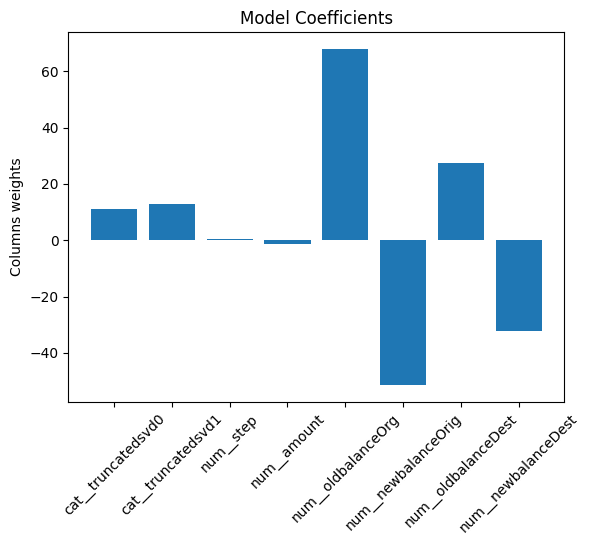

In [30]:
print(best_model['model'].coef_[0])
plot_coef(best_model['model'].feature_names_in_, best_model['model'].coef_[0])

In [31]:
print(best_model.score(X_train, y_train)*100)
best_model.score(X_test, y_test)*100

94.85997564793878


94.98782467532467

## Using SVC

In [32]:
from sklearn.svm import SVC

clf = Pipeline([
    
    ('transformer', transformer),
    ('model',SVC(kernel= 'linear', C=10) )
])

clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model', SVC(C=10, kernel='linear'))])

the traning accuracy of the model is 94.67999999999999%
the testing accuracy of the model is 94.64%
the precision of the model is 0.9464285714285714
the recall of the model is 0.9464641632783226
the f1 of the model is 0.9464275037369207


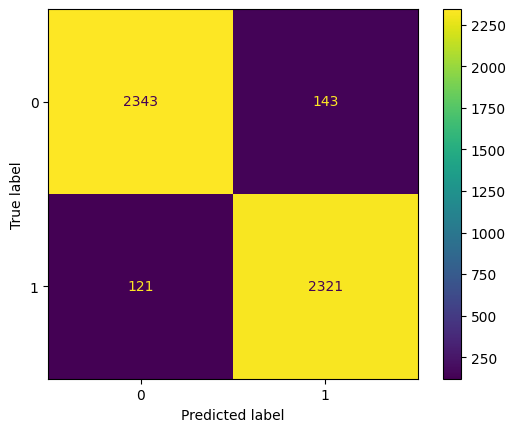

In [33]:
model_eveluation(clf)

# Tune SVC Pipeline 

In [34]:
from sklearn.model_selection import GridSearchCV

params = {
         
         'model__kernel':['rbf', 'linear','poly','sigmoid'],
         'model__C':np.random.uniform(0.001,500, 10)
         }

gscv = GridSearchCV(clf, params, cv=3, scoring = 'f1', n_jobs=-1)

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('model', SVC(C=10, kernel='linear'))]),
             n_jobs=-1,
             param_grid={'model__C': array([219.13990831, 296.7235883 , 223.13238708, 260.08962778,
       218.50935383, 488.13507398,  63.15767215, 311.09702142,
       334.46245725, 374.94628161]),
                         'model__kernel': ['rbf', 'linear', 'poly', 'sigmoid']},
             scoring='f1')

In [35]:
print(f'best params {gscv.best_params_}')
print(f'best f1 score {gscv.best_score_}') # avarage score of the validation split of the traning data
best_model = gscv.best_estimator_


best params {'model__C': 488.1350739782617, 'model__kernel': 'rbf'}
best f1 score 0.9747689914943964


In [36]:
print(best_model.score(X_train, y_train))
print(best_model.score(X_test, y_test))

0.9813010958427553
0.9756493506493507


## Using RandomForest

In [37]:
from sklearn.ensemble import RandomForestClassifier

clf = Pipeline([
    
    ('transformer', transformer),
    ('model',RandomForestClassifier(random_state=42) )
])

clf.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model', RandomForestClassifier(random_state=42))])

the traning accuracy of the model is 100.0%
the testing accuracy of the model is 99.31%
the precision of the model is 0.9931006493506493
the recall of the model is 0.9931474355595382
the f1 of the model is 0.9931004857068313


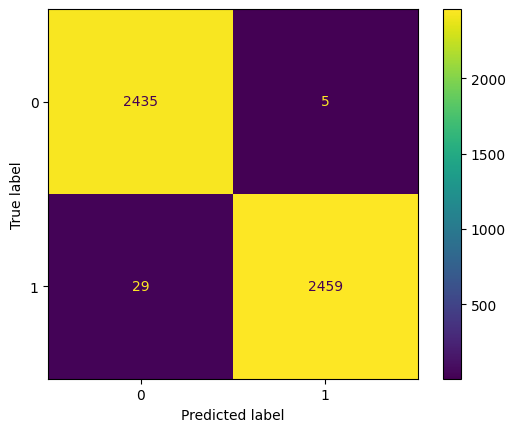

In [38]:
model_eveluation(clf)

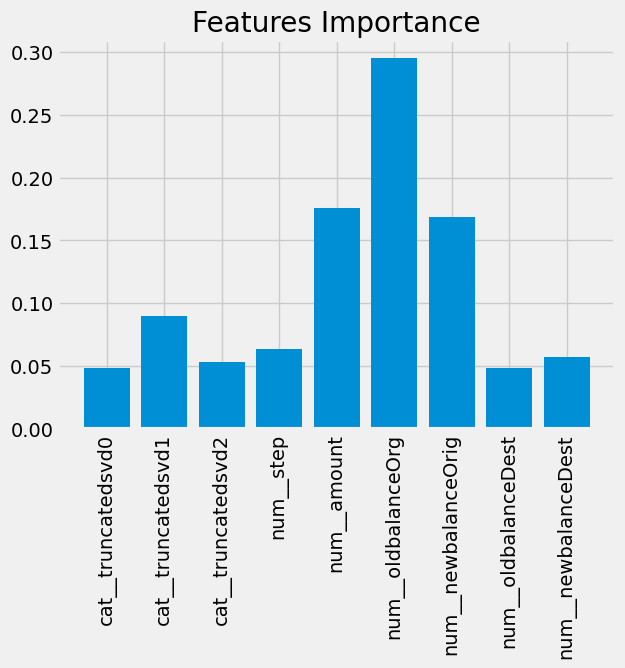

In [39]:
features_im = clf['model'].feature_importances_
col_names = clf['model'].feature_names_in_

#plt.style.use('ggplot') 
plt.style.use('fivethirtyeight')
plt.bar(col_names, features_im )
plt.xticks(rotation= 90)
plt.title('Features Importance')
plt.show()

# Tune RandomForest

In [40]:
params = {
          'model__n_estimators':[50, 100, 150,200],
          'model__max_depth': [3,5,10,15,20],
          'model__max_samples':[0.7, 0.9, 1.0]
    
           }
gscv = GridSearchCV(clf, params, cv=3, scoring='f1', n_jobs=-1)

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff...
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('stand',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('model',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'model__max_depth': [3, 5, 10, 15, 20],
                         'model__max_samples': [0.7, 0.9, 1.0],
                         'model__n_estimators': [50, 100, 150, 200]},
             scoring='f1')

In [41]:
print(f'RF best params {gscv.best_params_}')
print(f'RF best f1 score {gscv.best_score_}') # avarage score of the validation split of the traning data
best_model = gscv.best_estimator_


RF best params {'model__max_depth': 20, 'model__max_samples': 0.9, 'model__n_estimators': 100}
RF best f1 score 0.9903004863968987


the traning accuracy of the model is 100.0%
the testing accuracy of the model is 99.19%
the precision of the model is 0.9918831168831168
the recall of the model is 0.9919466430508662
the f1 of the model is 0.99188285483685
None


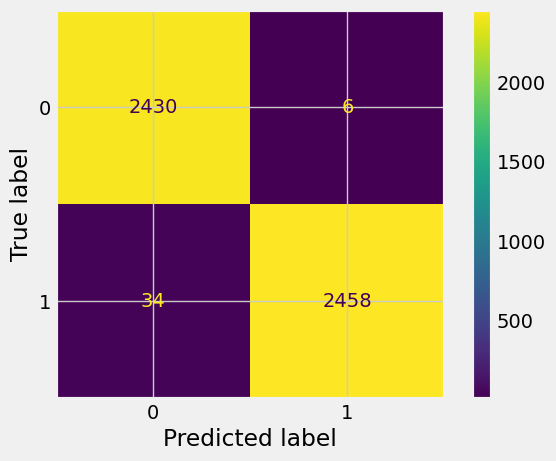

In [42]:
print(model_eveluation(best_model))

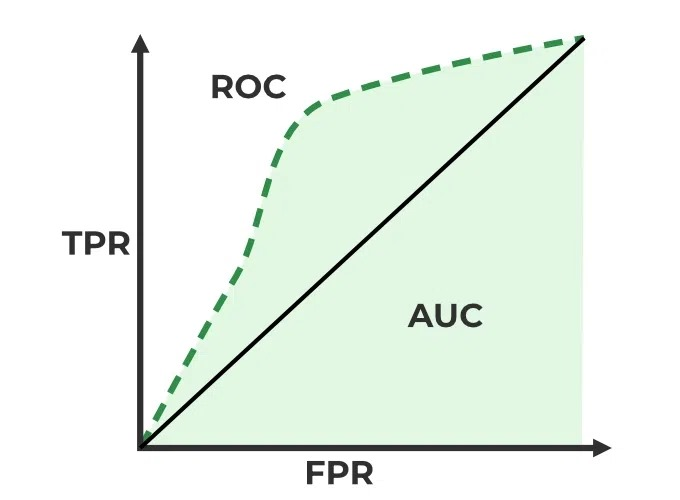

In [43]:
from xgboost import XGBClassifier


clf = Pipeline([
    
    ('trasn', transformer),
    ('model',XGBClassifier(learning_rate = 0.1, n_estimators=100))
])


clf.fit(X_train, y_train)

Pipeline(steps=[('trasn',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num...
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=100, n_jobs=None,
                               num_parallel_tree=None, random_state=None, ...))])

In [44]:
clf.score(X_train, y_train)

0.995999304226822

the traning accuracy of the model is 99.6%
the testing accuracy of the model is 99.35000000000001%
the precision of the model is 0.9935064935064934
the recall of the model is 0.993545838678582
the f1 of the model is 0.9935063640893238


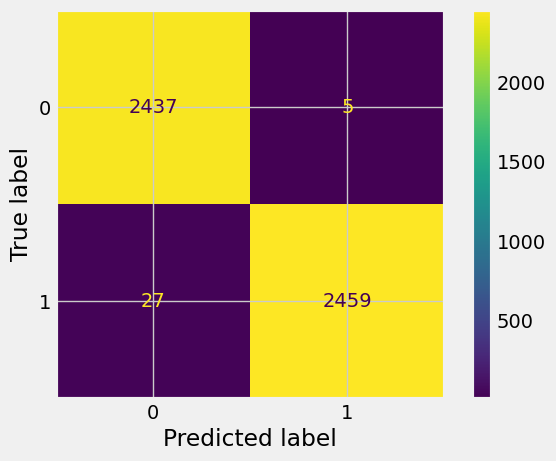

In [45]:
model_eveluation(clf)

# KNN

In [46]:
from sklearn.neighbors import KNeighborsClassifier

knn = Pipeline([
    ('transformer', transformer),
    ('model', KNeighborsClassifier())
])

knn.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model', KNeighborsClassifier())])

In [47]:
X_test = X_test.reset_index(drop=True)

In [48]:
X_test

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,203,CASH_OUT,161682.94,35313.00,0.00,118129.46,441788.40
1,470,CASH_OUT,120843.94,120843.94,0.00,1710553.99,1831397.93
2,736,TRANSFER,10000000.00,11314660.84,1314660.84,0.00,0.00
3,359,CASH_OUT,2056779.24,2056779.24,0.00,191822.43,2248601.67
4,109,CASH_OUT,20243.24,20243.24,0.00,1132460.42,1152703.66
...,...,...,...,...,...,...,...
4923,409,TRANSFER,9033760.73,9033760.73,0.00,0.00,0.00
4924,121,CASH_OUT,936976.86,936976.86,0.00,0.00,936976.86
4925,228,PAYMENT,14099.62,87.00,0.00,0.00,0.00
4926,53,TRANSFER,1631640.02,1631640.02,0.00,0.00,0.00


In [49]:
X_test.iloc[[0]]

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest
0,203,CASH_OUT,161682.94,35313.0,0.0,118129.46,441788.4


In [50]:
knn.predict(X_test.iloc[1].to_frame().T)

array([1])

In [51]:
knn.predict_proba(X_test.iloc[1].to_frame().T)

array([[0.4, 0.6]])

In [52]:
knn.predict_proba(X_test.iloc[1].to_frame().T).argmax()

1

In [53]:
X_test['prediction'] = knn.predict(X_test)
X_test['predcition_proba'] = knn.predict_proba(X_test)[:,1]
X_test

,step,type,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,prediction,predcition_proba
0,203,CASH_OUT,161682.94,35313.00,0.00,118129.46,441788.40,0,0.0
1,470,CASH_OUT,120843.94,120843.94,0.00,1710553.99,1831397.93,1,0.6
2,736,TRANSFER,10000000.00,11314660.84,1314660.84,0.00,0.00,1,1.0
3,359,CASH_OUT,2056779.24,2056779.24,0.00,191822.43,2248601.67,1,1.0
4,109,CASH_OUT,20243.24,20243.24,0.00,1132460.42,1152703.66,0,0.2
...,...,...,...,...,...,...,...,...,...
4923,409,TRANSFER,9033760.73,9033760.73,0.00,0.00,0.00,1,1.0
4924,121,CASH_OUT,936976.86,936976.86,0.00,0.00,936976.86,1,1.0
4925,228,PAYMENT,14099.62,87.00,0.00,0.00,0.00,0,0.0
4926,53,TRANSFER,1631640.02,1631640.02,0.00,0.00,0.00,1,1.0


the traning accuracy of the model is 95.66%
the testing accuracy of the model is 93.49%
the precision of the model is 0.934862012987013
the recall of the model is 0.9354048261077716
the f1 of the model is 0.934841705002736


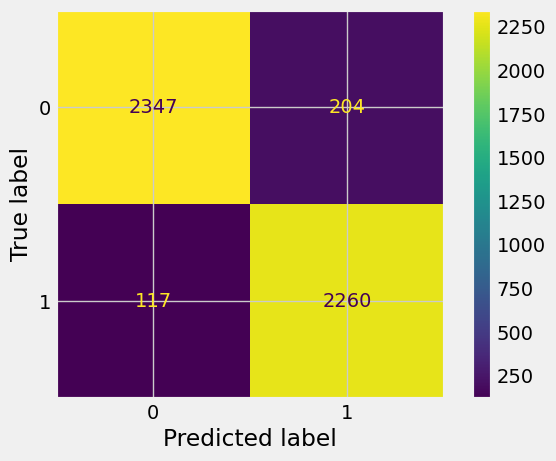

In [54]:
model_eveluation(knn)

In [55]:
params = {
    
    'model__n_neighbors':[5,7,10,15,30,50,100]
}

gscv = GridSearchCV(knn, params, cv=3, scoring = 'f1', n_jobs =-1)

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                                        ('num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('stand',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('model', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'model__n_neighbors': [5, 7, 10, 15, 30, 50, 100]},
             scoring='f1')

In [56]:
best_params = gscv.best_params_
best_params

{'model__n_neighbors': 5}

the traning accuracy of the model is 95.66%
the testing accuracy of the model is 93.49%
the precision of the model is 0.934862012987013
the recall of the model is 0.9354048261077716
the f1 of the model is 0.934841705002736


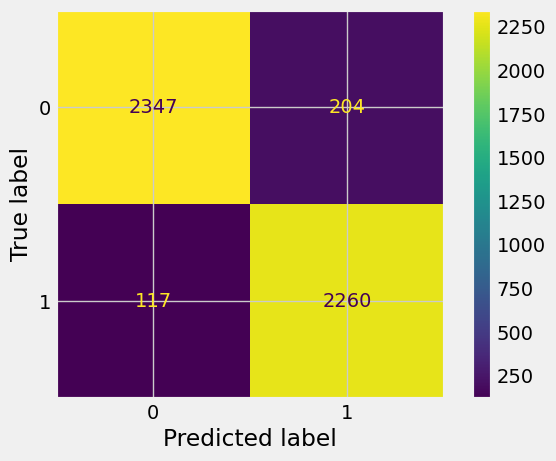

In [57]:
model = gscv.best_estimator_
model_eveluation(model)

In [58]:
# from sklearn.model_selection import cross_val_score

# for metric in ['f1', 'accuracy', 'precision', 'recall']:
#     print(metric, '= ',cross_val_score(clf, features, target, cv=10, n_jobs = -1, scoring=metric).mean()) 

# Voting

In [59]:
from sklearn.ensemble import VotingClassifier

vote = VotingClassifier(estimators=[
    
    ('logisticR', LogisticRegression(C=300, random_state=42)),
    ('RF', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('svm', SVC(C=500, random_state=42, probability=True))
], n_jobs= -1, verbose=True,  voting='soft') # 1- soft Soft Voting uses sum probablity from each model for each class
                                             # 2- hard majority vote 

vote_pipe = Pipeline([
    
    ('transfrom', transformer),
    ('model', vote)
])


vote_pipe.fit(X_train, y_train)


Pipeline(steps=[('transfrom',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[(...
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model',
                 VotingClassifier(estimators=[('logisticR',
                                               LogisticRegression(C=300,
                                                                  random_state=42)),
                                              ('RF',
                                               RandomForestClassifier(random_state=42)),
                                              ('svm',
                                               SVC(C=500, probability=True,
                                                   random_state=42))],
                                  n_jobs=-1, verbose=True, voting='soft'))])

the traning accuracy of the model is 99.37%
the testing accuracy of the model is 98.8%
the precision of the model is 0.9880275974025974
the recall of the model is 0.9880508291293355
the f1 of the model is 0.9880274549262


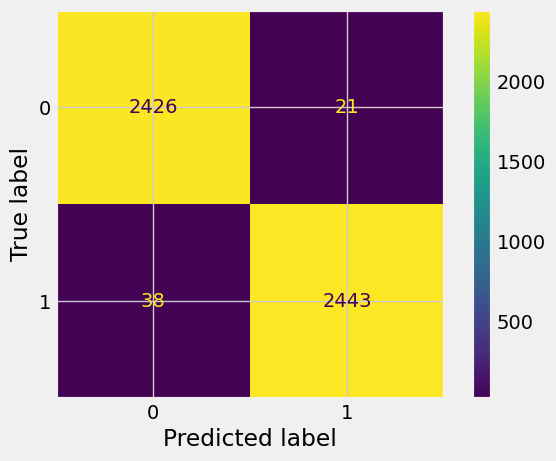

In [60]:
model_eveluation(vote_pipe)

In [61]:
params = {
    
    'model__estimators': [
                          [('log', LogisticRegression(C=500, max_iter=1000)), ('svc', SVC(probability= True, C=500)) ],
                          [('log', LogisticRegression(C=500, max_iter=1000)), ('svc', SVC(probability= True, C=500)), ('rf', RandomForestClassifier())],
                          [('svc', SVC(probability= True, C=500)), ('rf', RandomForestClassifier())]
                         
                         ]
}

gscv = GridSearchCV(vote_pipe, params, cv=3, n_jobs=-1, scoring = 'f1')

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transfrom',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d...
                                                         voting='soft'))]),
             n_jobs=-1,
             param_grid={'model__estimators': [[('log',
                                                 LogisticRegression(C=500,
                                                                    max_iter=1000)),
                                                ('svc',
                                                 SVC(C=500, probability=True))],
                                               [('log',
                                                 LogisticRegression(C=500,
                                                                    max_iter=1000)),
                                                ('svc',
                                                 SVC(C=500, probability=True)),
                                                ('rf',
                                                 RandomForestClassifier())],
                                               [('svc',
                                                 SVC(C=500, probability=True)),
                                                ('rf',
                                                 RandomForestClassifier())]]},
             scoring='f1')

In [62]:
print('best params', gscv.best_params_)
print('best score', gscv.best_score_)
best_model = gscv.best_estimator_
best_model

best params {'model__estimators': [('svc', SVC(C=500, probability=True)), ('rf', RandomForestClassifier())]}
best score 0.9885537511097056


Pipeline(steps=[('transfrom',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x786343d3bcd0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x786343d3bd60>)])),
                ('model',
                 VotingClassifier(estimators=[('svc',
                                               SVC(C=500, probability=True)),
                                              ('rf', RandomForestClassifier())],
                                  n_jobs=-1, verbose=True, voting='soft'))])

In [63]:
pd.DataFrame.from_dict(gscv.cv_results_)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__estimators,params,split0_test_score,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score
0,6.973903,0.162024,0.428578,0.051519,"[(log, LogisticRegression(C=500, max_iter=1000...","{'model__estimators': [('log', LogisticRegress...",0.976853,0.973226,0.979901,0.976660,0.002728,3
1,7.478500,0.655612,0.453193,0.033915,"[(log, LogisticRegression(C=500, max_iter=1000...","{'model__estimators': [('log', LogisticRegress...",0.986194,0.985152,0.988530,0.986625,0.001412,2
2,6.531653,1.700665,0.353252,0.094236,"[(svc, SVC(C=500, probability=True)), (rf, Ran...","{'model__estimators': [('svc', SVC(C=500, prob...",0.989320,0.985974,0.990367,0.988554,0.001874,1


the traning accuracy of the model is 99.53999999999999%
the testing accuracy of the model is 99.11%
the precision of the model is 0.9910714285714286
the recall of the model is 0.9910921357790428
the f1 of the model is 0.9910713344507343


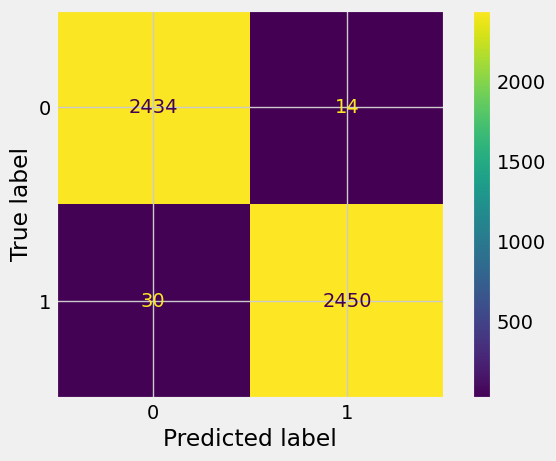

In [64]:
model_eveluation(best_model)

# *Using Bagging*

In [65]:
from sklearn.ensemble import BaggingClassifier # default estimator Decision Tree and n_estimators= 10

#bc = BaggingClassifier(estimator= LogisticRegression(C =500, max_iter=1000, solver= 'newton-cg'), n_estimators= 200, n_jobs= -1, random_state = 42)

#bc = BaggingClassifier(estimator= KNeighborsClassifier(n_neighbors=5), n_estimators= 100, n_jobs= -1, random_state = 42)

bc = BaggingClassifier()
bc_pipe = Pipeline([
    
    
   ('transformer', transformer),
   ('model', bc)
    
])


bc_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('model', BaggingClassifier())])

the traning accuracy of the model is 99.97%
the testing accuracy of the model is 99.59%
the precision of the model is 0.9959415584415585
the recall of the model is 0.9959497272036679
the f1 of the model is 0.9959415417298948


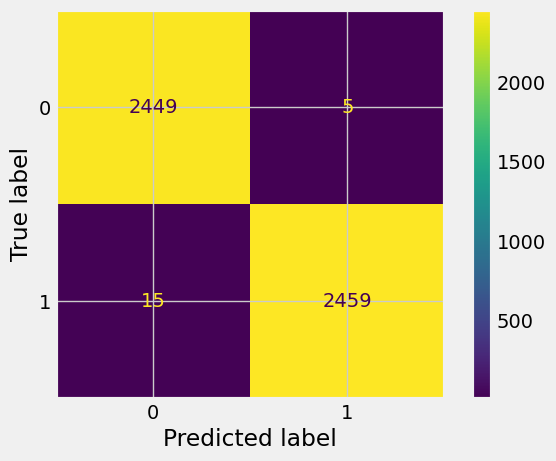

In [66]:
model_eveluation(bc_pipe)

In [67]:
from sklearn.tree import DecisionTreeClassifier
params = {
    
    'model__estimator':[LogisticRegression(), KNeighborsClassifier(), DecisionTreeClassifier()],
    'model__n_estimators': [50,100,150]
    
}

gscv = GridSearchCV(bc_pipe, params, cv=3, n_jobs=-1, scoring='accuracy')

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff...
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('stand',
                                                                                          StandardScaler())]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('model', BaggingClassifier())]),
             n_jobs=-1,
             param_grid={'model__estimator': [LogisticRegression(),
                                              KNeighborsClassifier(),
                                              DecisionTreeClassifier()],
                         'model__n_estimators': [50, 100, 150]},
             scoring='accuracy')

In [68]:
gscv.best_params_

{'model__estimator': DecisionTreeClassifier(), 'model__n_estimators': 100}

the traning accuracy of the model is 100.0%
the testing accuracy of the model is 99.39%
the precision of the model is 0.9939123376623377
the recall of the model is 0.9939448806238815
the f1 of the model is 0.9939122373911171


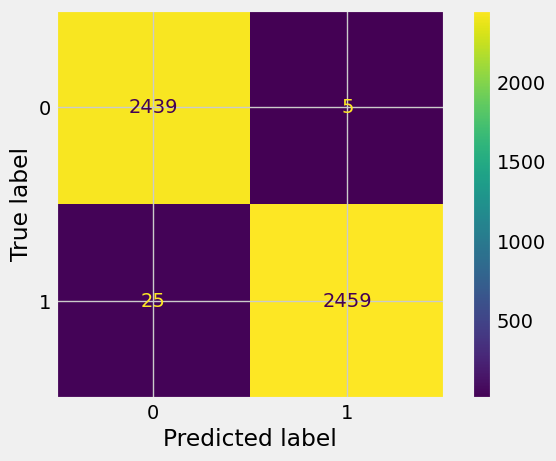

In [69]:
model_eveluation(gscv)

# *Neural Network*

In [70]:
from sklearn.neural_network import MLPClassifier 

# clf = MLPClassifier(hidden_layer_sizes= (150),
#                     activation="relu", 
#                     solver="adam", 
#                     learning_rate="adaptive",
#                     learning_rate_init=0.001,
#                     max_iter=500,
#                    validation_fraction=0.1)

clf = MLPClassifier(max_iter = 2000)


mlp_pipe = Pipeline([
    
    ('transformer', transformer),
    ('clf', clf)
])

mlp_pipe.fit(X_train, y_train)

Pipeline(steps=[('transformer',
                 ColumnTransformer(transformers=[('cat',
                                                  Pipeline(steps=[('cat_impute',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse_output=False)),
                                                                  ('dr',
                                                                   TruncatedSVD(n_components=3))]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff6d0>),
                                                 ('num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('stand',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                ('clf', MLPClassifier(max_iter=2000))])

the traning accuracy of the model is 97.92%
the testing accuracy of the model is 97.52%
the precision of the model is 0.9752435064935066
the recall of the model is 0.9752463244861858
the f1 of the model is 0.9752434697947898


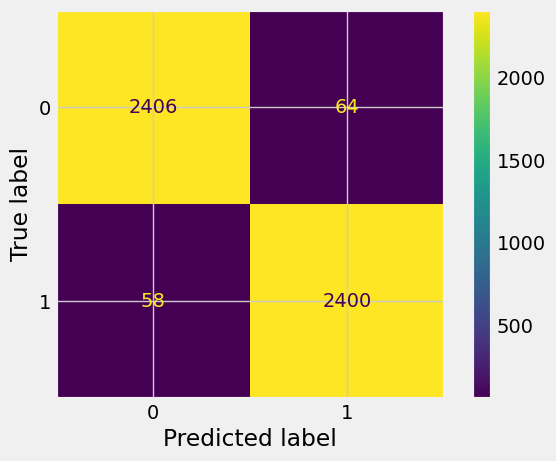

In [71]:
model_eveluation(mlp_pipe)

In [72]:
params = {
    
    'clf__hidden_layer_sizes':[(50), (50,100), (50,100,150)],
    'clf__learning_rate':['constant', 'adaptive'],
    'clf__learning_rate_init':[0.001,0.01, 0.0001],
    'clf__alpha':[0.01,0.001,1,200, 500],
    'clf__activation':['relu', 'logistic', 'tanh'],
    

    
    
}

gscv = GridSearchCV(mlp_pipe, params, cv=3, n_jobs=-1, scoring= 'f1')

gscv.fit(X_train, y_train)

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('transformer',
                                        ColumnTransformer(transformers=[('cat',
                                                                         Pipeline(steps=[('cat_impute',
                                                                                          SimpleImputer(strategy='most_frequent')),
                                                                                         ('ohe',
                                                                                          OneHotEncoder(handle_unknown='ignore',
                                                                                                        sparse_output=False)),
                                                                                         ('dr',
                                                                                          TruncatedSVD(n_components=3))]),
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                       ('clf', MLPClassifier(max_iter=2000))]),
             n_jobs=-1,
             param_grid={'clf__activation': ['relu', 'logistic', 'tanh'],
                         'clf__alpha': [0.01, 0.001, 1, 200, 500],
                         'clf__hidden_layer_sizes': [50, (50, 100),
                                                     (50, 100, 150)],
                         'clf__learning_rate': ['constant', 'adaptive'],
                         'clf__learning_rate_init': [0.001, 0.01, 0.0001]},
             scoring='f1')

In [73]:
gscv.best_score_

0.9808752135404569

In [74]:
gscv.best_params_

{'clf__activation': 'tanh',
 'clf__alpha': 0.001,
 'clf__hidden_layer_sizes': (50, 100, 150),
 'clf__learning_rate': 'constant',
 'clf__learning_rate_init': 0.001}

the traning accuracy of the model is 97.69%
the testing accuracy of the model is 97.22%
the precision of the model is 0.9721996753246753
the recall of the model is 0.973194887140059
the f1 of the model is 0.9721850503956858


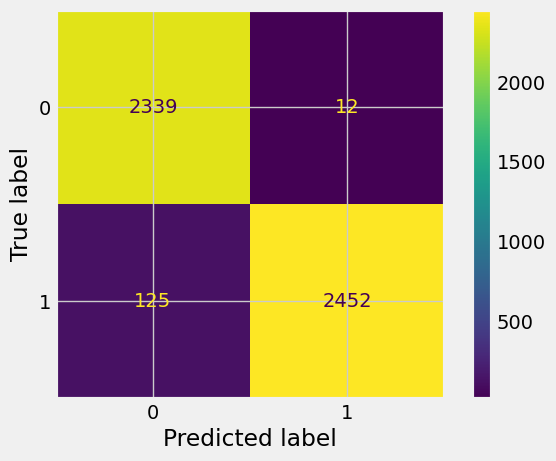

In [75]:
model_eveluation(gscv.best_estimator_)

In [76]:
from sklearn.model_selection import RandomizedSearchCV

rscv = RandomizedSearchCV(mlp_pipe, params, n_jobs=-1, scoring='f1', cv=2, n_iter=150)

rscv.fit(X_train, y_train)

RandomizedSearchCV(cv=2,
                   estimator=Pipeline(steps=[('transformer',
                                              ColumnTransformer(transformers=[('cat',
                                                                               Pipeline(steps=[('cat_impute',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(handle_unknown='ignore',
                                                                                                              sparse_output=False)),
                                                                                               ('dr',
                                                                                                TruncatedSVD(n_components=3))]),
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x786...
                                                                               <sklearn.compose._column_transformer.make_column_selector object at 0x7863491ff8b0>)])),
                                             ('clf',
                                              MLPClassifier(max_iter=2000))]),
                   n_iter=150, n_jobs=-1,
                   param_distributions={'clf__activation': ['relu', 'logistic',
                                                            'tanh'],
                                        'clf__alpha': [0.01, 0.001, 1, 200,
                                                       500],
                                        'clf__hidden_layer_sizes': [50,
                                                                    (50, 100),
                                                                    (50, 100,
                                                                     150)],
                                        'clf__learning_rate': ['constant',
                                                               'adaptive'],
                                        'clf__learning_rate_init': [0.001, 0.01,
                                                                    0.0001]},
                   scoring='f1')

In [77]:
rscv.best_params_

{'clf__learning_rate_init': 0.001,
 'clf__learning_rate': 'constant',
 'clf__hidden_layer_sizes': (50, 100, 150),
 'clf__alpha': 0.001,
 'clf__activation': 'tanh'}

In [78]:
pd.DataFrame(rscv.cv_results_).sort_values('mean_test_score', ascending = False)

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_clf__learning_rate_init,param_clf__learning_rate,param_clf__hidden_layer_sizes,param_clf__alpha,param_clf__activation,params,split0_test_score,split1_test_score,mean_test_score,std_test_score,rank_test_score
17,29.364218,2.568051,0.150794,0.001534,0.001,constant,"(50, 100, 150)",0.001,tanh,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.978532,0.975141,0.976837,0.001695,1
108,15.446616,3.918713,0.052110,0.004854,0.001,adaptive,"(50, 100, 150)",0.01,relu,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.978105,0.973177,0.975641,0.002464,2
45,8.656732,0.510423,0.089179,0.000222,0.01,adaptive,"(50, 100)",0.001,tanh,"{'clf__learning_rate_init': 0.01, 'clf__learni...",0.972641,0.977073,0.974857,0.002216,3
123,9.348702,0.692441,0.033449,0.001837,0.001,constant,"(50, 100)",0.001,relu,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.976970,0.970750,0.973860,0.003110,4
70,9.523823,0.219035,0.047555,0.000939,0.001,adaptive,"(50, 100, 150)",0.001,relu,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.971668,0.974970,0.973319,0.001651,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110,0.917583,0.041900,0.047500,0.021286,0.001,adaptive,50,200,relu,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.000000,0.000000,0.000000,0.000000,135
134,0.869794,0.001006,0.027212,0.000999,0.001,adaptive,50,500,relu,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.000000,0.000000,0.000000,0.000000,135
22,1.498524,0.275923,0.049649,0.000989,0.01,constant,"(50, 100)",500,logistic,"{'clf__learning_rate_init': 0.01, 'clf__learni...",0.000000,0.000000,0.000000,0.000000,135
125,3.905013,0.029685,0.091948,0.001767,0.001,adaptive,"(50, 100)",200,tanh,"{'clf__learning_rate_init': 0.001, 'clf__learn...",0.000000,0.000000,0.000000,0.000000,135


the traning accuracy of the model is 97.54%
the testing accuracy of the model is 97.08%
the precision of the model is 0.9707792207792207
the recall of the model is 0.9708043456632645
the f1 of the model is 0.9707788309259349


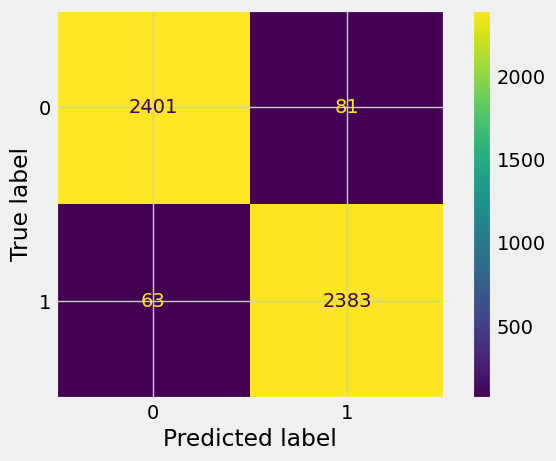

In [79]:
model_eveluation(rscv.best_estimator_)

In [80]:
cross_val_score(rscv.best_estimator_, features, target, cv= 5, n_jobs= -1, scoring='f1' ).mean()

0.9209324776673166